In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters

In [15]:
file = 'data/salesdaily.csv'
df = pd.read_csv(file)

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2106 entries, 0 to 2105
Data columns (total 13 columns):
datum           2106 non-null object
M01AB           2106 non-null float64
M01AE           2106 non-null float64
N02BA           2106 non-null float64
N02BE           2106 non-null float64
N05B            2106 non-null float64
N05C            2106 non-null float64
R03             2106 non-null float64
R06             2106 non-null float64
Year            2106 non-null int64
Month           2106 non-null int64
Hour            2106 non-null int64
Weekday Name    2106 non-null object
dtypes: float64(8), int64(3), object(2)
memory usage: 214.0+ KB


In [17]:
df.head()

,datum,M01AB,M01AE,N02BA,N02BE,N05B,N05C,R03,R06,Year,Month,Hour,Weekday Name
0,1/2/2014,0.0,3.67,3.4,32.40,7.0,0.0,0.0,2.0,2014,1,248,Thursday
1,1/3/2014,8.0,4.00,4.4,50.60,16.0,0.0,20.0,4.0,2014,1,276,Friday
2,1/4/2014,2.0,1.00,6.5,61.85,10.0,0.0,9.0,1.0,2014,1,276,Saturday
3,1/5/2014,4.0,3.00,7.0,41.10,8.0,0.0,3.0,0.0,2014,1,276,Sunday
4,1/6/2014,5.0,1.00,4.5,21.70,16.0,2.0,6.0,2.0,2014,1,276,Monday


- M01AB - Anti-inflammatory and antirheumatic products, non-steroids, Acetic acid derivatives and related substances
- M01AE - Anti-inflammatory and antirheumatic products, non-steroids, Propionic acid derivatives
- N02BA - Other analgesics and antipyretics, Salicylic acid and derivatives
- N02BE - Other analgesics and antipyretics, Pyrazolones and Anilides
- N05B - Psycholeptics drugs, Anxiolytic drugs
- N05C - Psycholeptics drugs, Hypnotics and sedatives drugs
- R03 - Drugs for obstructive airway diseases
- R06 - Antihistamines for systemic use

In [29]:
atc_codes = {'Antirheumatic' : ['M01AB','M01AE'],
             'Analgesics' : ['N02BA','N02BE'],
             'Psycholeptics' : ['N05C','N05B'],
             'Airway diseases': ['R03'],
             'Antihistamines': ['R06']}

In [42]:
def create_charts(data, codes, chart_name, index):
    fig, ax = plt.subplots(1, 1, sharex=True, figsize=(15,5))
    for cols in codes:
        ax.set_title('{} market'.format(chart_name))
        plt.plot(index, data[cols])
        register_matplotlib_converters()
        plt.legend();

In [38]:
df['datum'] = pd.to_datetime(df['datum'])

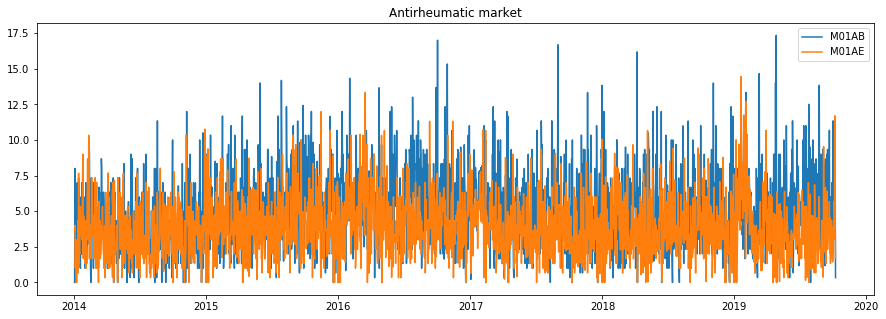

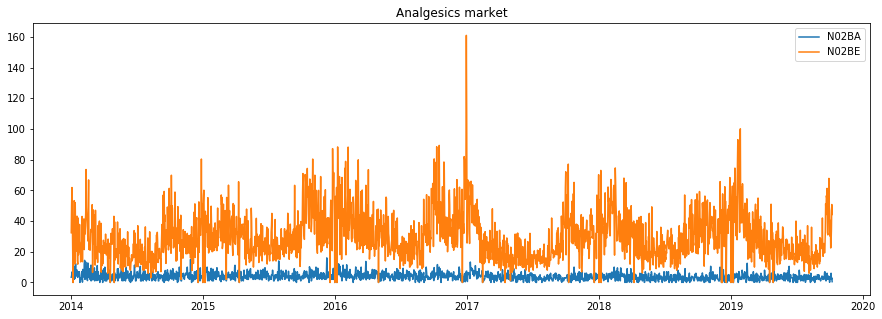

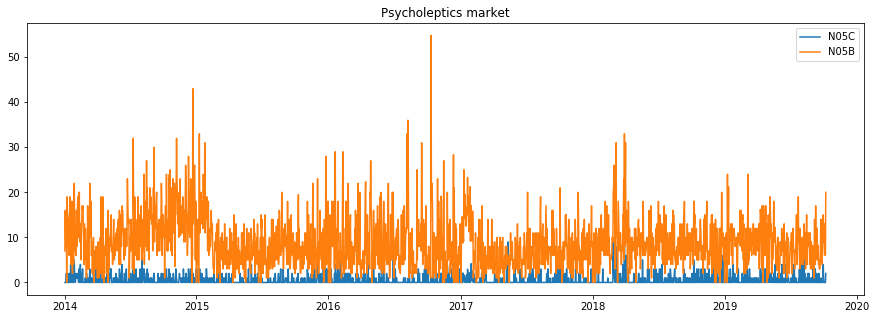

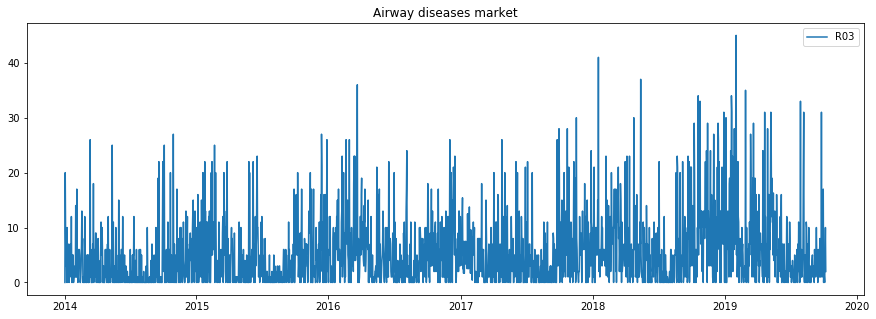

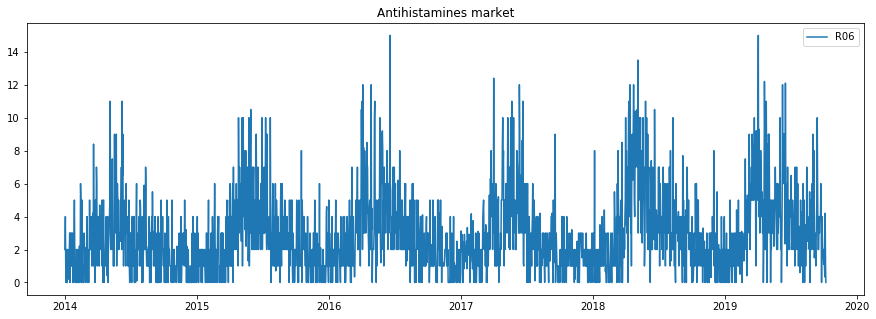

In [43]:
for market in atc_codes.items():
    create_charts(df, market[1], market[0], df.datum)

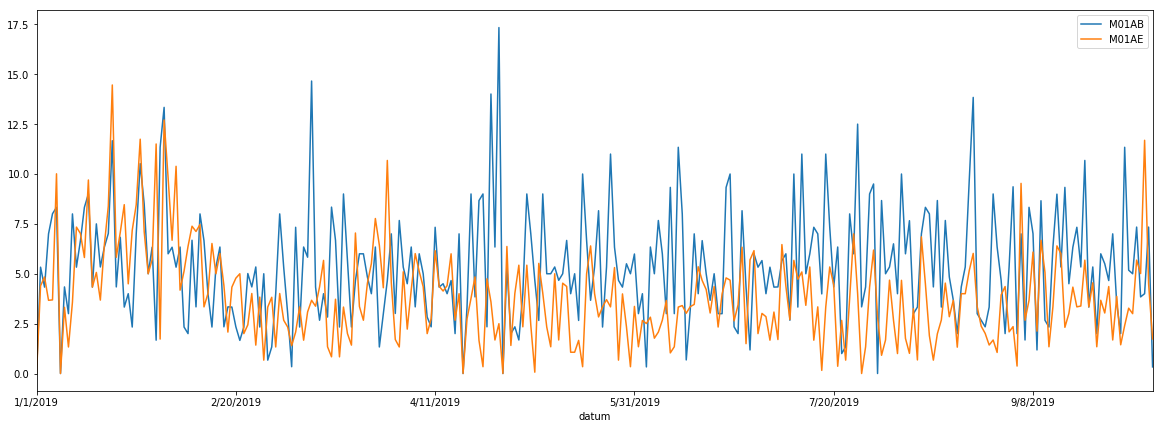

In [67]:
df[rheumatic_codes]['1/1/2019':].plot(figsize=(20,7))

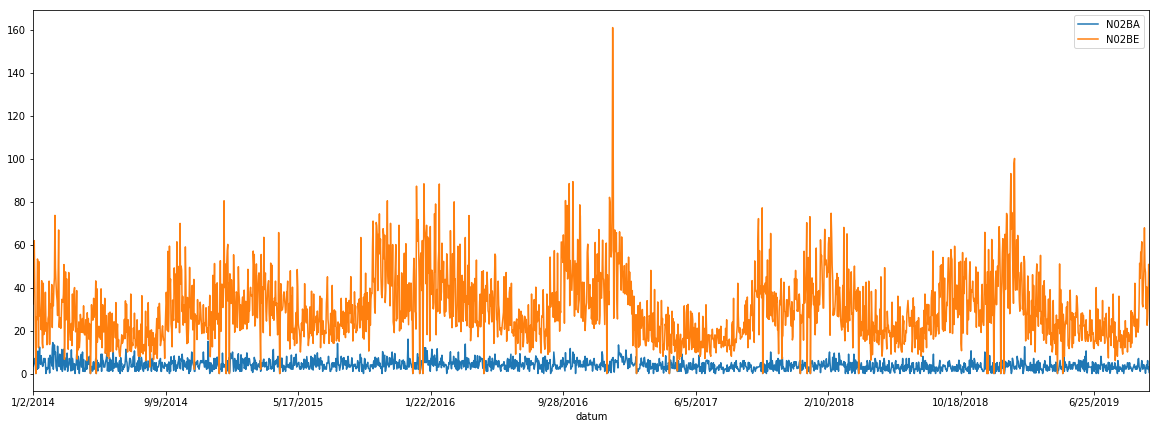

In [68]:
df[analgesics_codes].plot(figsize=(20,7))

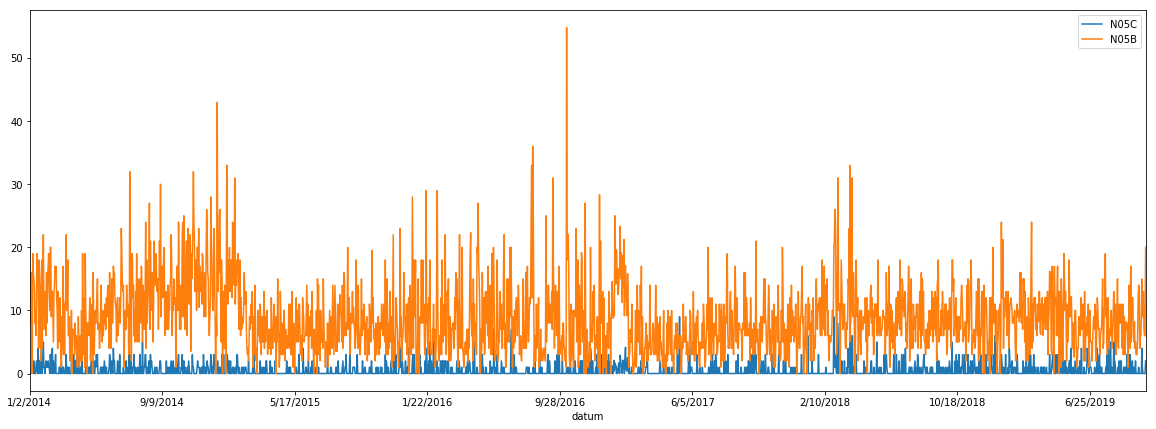

In [54]:
df[psycho_codes].plot(figsize=(20,7))

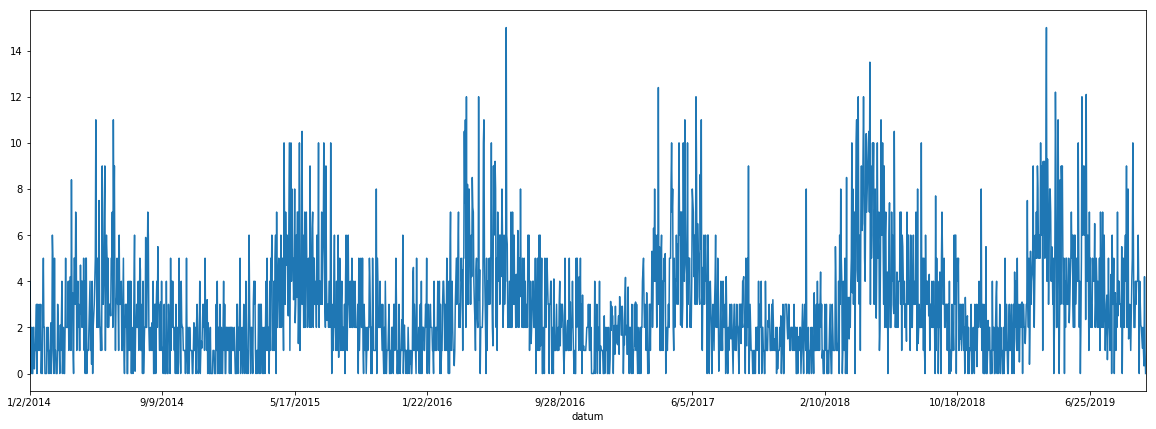

In [65]:
df['R06'].plot(figsize=(20,7))